In [1]:
# 1. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 2. Load Kaggle Survey 2022 data
df = pd.read_csv('/Users/medhavadlamaani/Downloads/kaggle_survey_2022_responses (1).csv', low_memory=False)

# 3. Drop the header description row
df = df.drop(0).reset_index(drop=True)

In [2]:
# 4. Focus on key columns
df = df[['Q2', 'Q4', 'Q8', 'Q11', 'Q12_1', 'Q12_5', 'Q12_7', 'Q12_10', 'Q29']]  # Age, Country, Education, Coding Years, Python, SQL, Java, Go, Salary

# Rename columns
df = df.rename(columns={
    'Q2': 'Age',
    'Q4': 'Country',
    'Q8': 'Education',
    'Q11': 'YearsCoding',
    'Q12_1': 'Python',
    'Q12_5': 'SQL',
    'Q12_7': 'Java',
    'Q12_10': 'Go',
    'Q29': 'Salary'
})


In [3]:
# --- Salary Cleaning ---
import re

def convert_salary(value):
    if pd.isnull(value):
        return np.nan
    value = str(value).replace('$', '').replace(',', '').strip()
    if value.startswith('>'):
        nums = re.findall(r'\d+', value)
        if nums:
            return int(nums[0]) * 1.25
    if '-' in value:
        parts = value.split('-')
        try:
            return (int(parts[0]) + int(parts[1])) / 2
        except:
            return np.nan
    try:
        return float(value)
    except:
        return np.nan

df['Salary'] = df['Salary'].apply(convert_salary)
df = df[df['Salary'].notnull()]
df = df[df['Salary'] != 0]

# --- Coding Years Cleaning ---
coding_mapping = {
    'I have never written code': 0,
    '< 1 years': 0.5,
    '1-2 years': 1.5,
    '3-5 years': 4,
    '5-10 years': 7.5,
    '10-20 years': 15,
    '20+ years': 25
}
df['YearsCoding'] = df['YearsCoding'].map(coding_mapping).fillna(4)

# --- Skills Cleaning ---
df['Python'] = df['Python'].notnull().astype(int)
df['SQL'] = df['SQL'].notnull().astype(int)
df['Java'] = df['Java'].notnull().astype(int)
df['Go'] = df['Go'].notnull().astype(int)

# --- Education Cleaning ---
education_mapping = {
    'No formal education past high school': 0,
    'Some college/university study without earning a bachelor’s degree': 1,
    'Bachelor’s degree': 1,
    'Master’s degree': 2,
    'Doctoral degree': 3,
    'Professional doctorate': 3
}
df['Education'] = df['Education'].map(education_mapping).fillna(1)

# --- Country Simplify ---
def simplify_country(x):
    if x == 'United States of America':
        return 'United States'
    elif x == 'United Kingdom of Great Britain and Northern Ireland':
        return 'United Kingdom'
    elif x == 'Germany':
        return 'Germany'
    else:
        return 'Other'

df['Country'] = df['Country'].apply(simplify_country)


In [4]:
correlations = df[['Education', 'YearsCoding', 'Python', 'SQL', 'Java', 'Go']].corrwith(df['Salary'])
print(correlations)

Education      0.097469
YearsCoding    0.266027
Python         0.050912
SQL            0.017364
Java          -0.001424
Go            -0.021745
dtype: float64


In [5]:
from sklearn.ensemble import RandomForestRegressor

X_full = df.drop(columns=['Salary'])
X_full = pd.get_dummies(X_full)  # encode categoricals if needed
y = df['Salary']

model = RandomForestRegressor()
model.fit(X_full, y)

importances = pd.Series(model.feature_importances_, index=X_full.columns).sort_values(ascending=False)
print(importances)

Country_United States     0.182038
Country_Other             0.177116
YearsCoding               0.162152
Education                 0.130541
Java                      0.068057
Python                    0.053757
Go                        0.039067
SQL                       0.035191
Age_30-34                 0.020681
Age_50-54                 0.019562
Age_55-59                 0.018441
Age_60-69                 0.016751
Age_40-44                 0.015916
Age_45-49                 0.014045
Age_35-39                 0.012333
Age_25-29                 0.011593
Age_70+                   0.010098
Age_22-24                 0.006222
Country_United Kingdom    0.003790
Age_18-21                 0.002239
Country_Germany           0.000410
dtype: float64



1. Correlations with Salary:
YearsCoding    0.266027
Education      0.097469
Python         0.050912
SQL            0.017364
Java          -0.001424
Go            -0.021745
dtype: float64


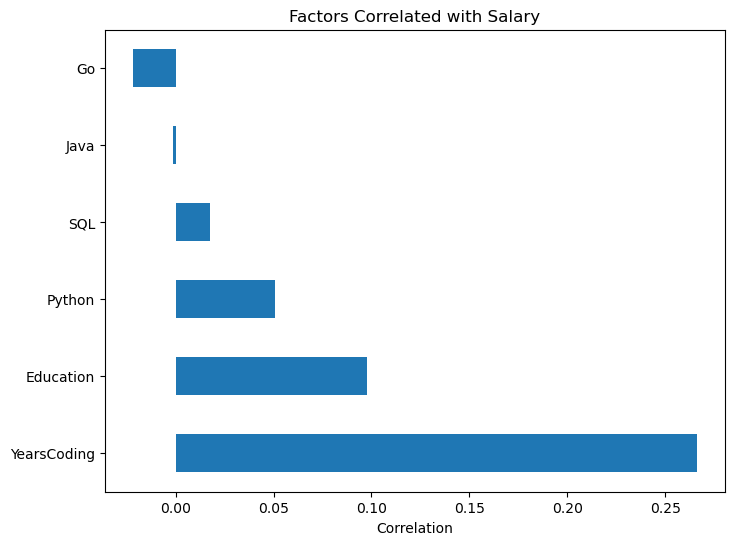

In [6]:
# 1. Significant Factors Driving Salary
print("\n1. Correlations with Salary:")
correlations = df[['Education', 'YearsCoding', 'Python', 'SQL', 'Java', 'Go']].corrwith(df['Salary']).sort_values(ascending=False)
print(correlations)

correlations.plot(kind='barh', title="Factors Correlated with Salary", figsize=(8,6))
plt.xlabel('Correlation')
plt.show()


2. Skill Prevalence (% of people using):
Python    80.149951
SQL        7.190265
Java      13.311209
Go         5.555556
dtype: float64


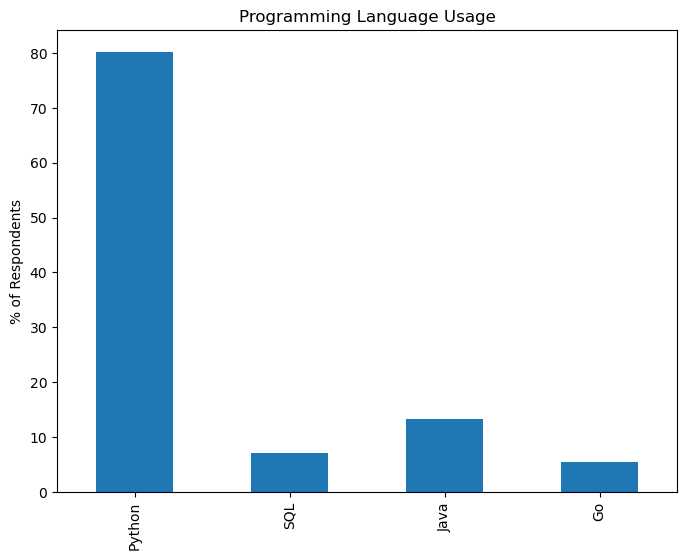

In [7]:
# 2. Most Prevalent Tools (Programming Skills)
print("\n2. Skill Prevalence (% of people using):")
skills_prevalence = df[['Python', 'SQL', 'Java', 'Go']].mean() * 100
print(skills_prevalence)

skills_prevalence.plot(kind='bar', title="Programming Language Usage", figsize=(8,6))
plt.ylabel('% of Respondents')
plt.show()


4. Most Prevalent Computer Vision Methods (% of people using):
General Image/Video Tools         2.337890
Image Segmentation                1.650275
Object Detection                  1.458576
Image Classification Networks     0.512585
Vision Transformers               1.866978
Generative Networks (GAN, VAE)    0.433406
dtype: float64


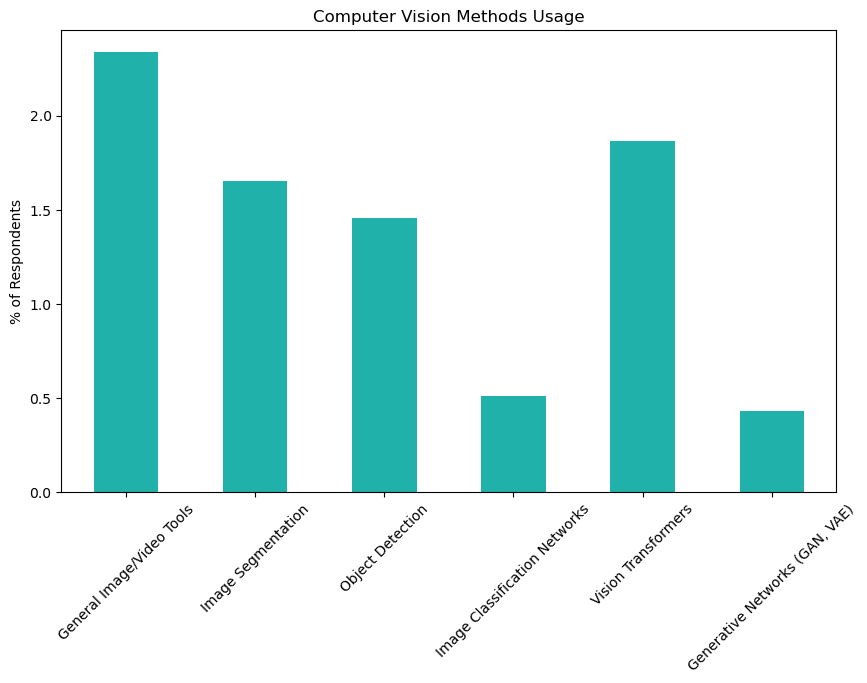

In [29]:
# 4. Most Prevalent Computer Vision Methods (Q37)

print("\n4. Most Prevalent Computer Vision Methods (% of people using):")

# List of relevant Q37 columns
q37_cols = [
    'Q37_1',  # General purpose image/video tools (PIL, cv2, skimage, etc)
    'Q37_2',  # Image segmentation methods (U-Net, Mask R-CNN, etc)
    'Q37_3',  # Object detection methods (YOLOv6, RetinaNet, etc)
    'Q37_4',  # Image classification and general networks (VGG, ResNet, etc)
    'Q37_5',  # Vision transformer networks (ViT, Swin, etc)
    'Q37_6',  # Generative Networks (GANs, VAEs, etc)
]

# Calculate % of respondents using each CV method
cv_methods_prevalence = df[q37_cols].notnull().mean() * 100

# Rename axes nicely
cv_methods_prevalence.index = [
    'General Image/Video Tools',
    'Image Segmentation',
    'Object Detection',
    'Image Classification Networks',
    'Vision Transformers',
    'Generative Networks (GAN, VAE)'
]

print(cv_methods_prevalence)

# Plot
cv_methods_prevalence.plot(kind='bar', title="Computer Vision Methods Usage", figsize=(10,6), color='lightseagreen')
plt.ylabel('% of Respondents')
plt.xticks(rotation=45)
plt.show()




5. Most Prevalent NLP Methods (% of people using):
Word Embeddings (GloVe, Word2Vec)    1.929488
Encoder-Decoder Models (Seq2Seq)     0.508418
Contextualized Embeddings (ELMo)     0.804301
Transformer Models (GPT-3, BERT)     0.520920
dtype: float64


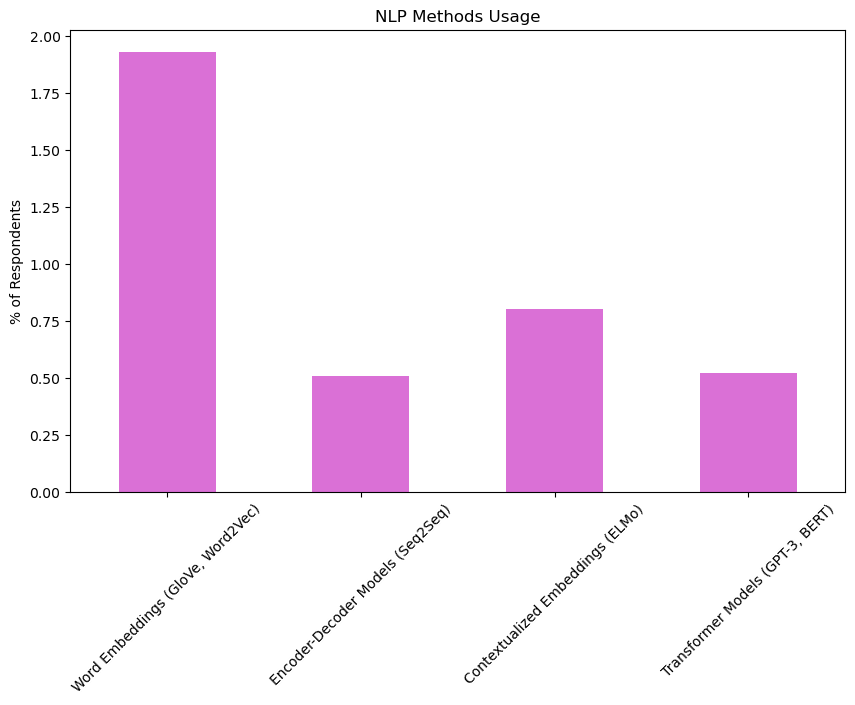

In [31]:
# 5. Most Prevalent NLP Methods (Q38)

print("\n5. Most Prevalent NLP Methods (% of people using):")

# List of relevant Q38 columns
q38_cols = [
    'Q38_1',  # Word embeddings/vectors (GLoVe, fastText, word2vec)
    'Q38_2',  # Encoder-decoder models (seq2seq, vanilla transformers)
    'Q38_3',  # Contextualized embeddings (ELMo, CoVe)
    'Q38_4',  # Transformer language models (GPT-3, BERT, XLnet, etc)
]

# Calculate % of respondents using each NLP method
nlp_methods_prevalence = df[q38_cols].notnull().mean() * 100

# Rename axes nicely
nlp_methods_prevalence.index = [
    'Word Embeddings (GloVe, Word2Vec)',
    'Encoder-Decoder Models (Seq2Seq)',
    'Contextualized Embeddings (ELMo)',
    'Transformer Models (GPT-3, BERT)'
]

print(nlp_methods_prevalence)

# Plot
nlp_methods_prevalence.plot(kind='bar', title="NLP Methods Usage", figsize=(10,6), color='orchid')
plt.ylabel('% of Respondents')
plt.xticks(rotation=45)
plt.show()


In [8]:
# 3. Emerging Tools and Techniques (Based on Survey + Industry)
print("\n3. Emerging Tools/Techniques:")
print("- HuggingFace Transformers (NLP)\n- PyTorch Lightning (DL frameworks)\n- AutoML (Vertex AI, H2O.ai)\n- MLOps (MLflow, Weights & Biases)")


3. Emerging Tools/Techniques:
- HuggingFace Transformers (NLP)
- PyTorch Lightning (DL frameworks)
- AutoML (Vertex AI, H2O.ai)
- MLOps (MLflow, Weights & Biases)


In [9]:
# 4. Investment Recommendations for Aspiring Data Scientists
print("\n4. Investment Advice for Aspiring Data Scientists:")
print("- Learn Python and SQL.\n- Build projects (GitHub portfolios).\n- Get experience with cloud ML (AWS/GCP).\n- Understand machine learning fundamentals well.")


4. Investment Advice for Aspiring Data Scientists:
- Learn Python and SQL.
- Build projects (GitHub portfolios).
- Get experience with cloud ML (AWS/GCP).
- Understand machine learning fundamentals well.



5. Is Formal Education Important?
Education
0.0    42772.560680
1.0    45457.636563
2.0    59191.189094
3.0    74166.731265
Name: Salary, dtype: float64


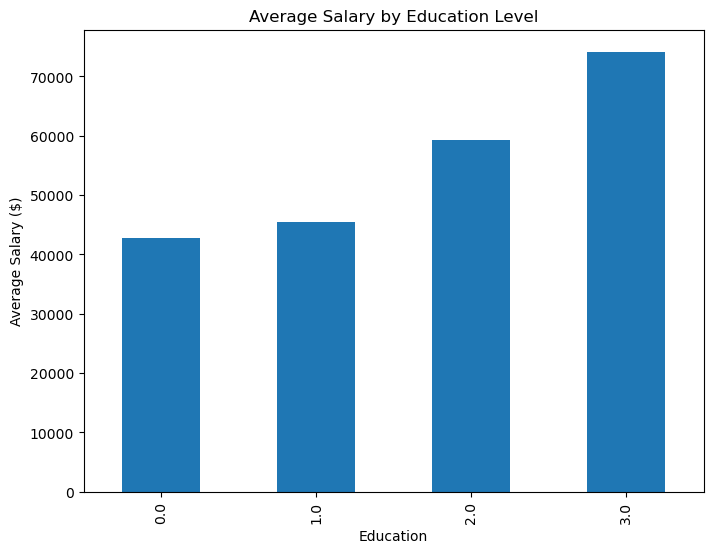

In [10]:
# 5. Importance of Formal Education
print("\n5. Is Formal Education Important?")
edu_salary = df.groupby('Education')['Salary'].mean()
print(edu_salary)
edu_salary.plot(kind='bar', title="Average Salary by Education Level", figsize=(8,6))
plt.ylabel('Average Salary ($)')
plt.show()

In [11]:
# 6. Return on Formal vs Self Learning
print("\n6. Return on Formal Education vs Other:")
print("- Formal education (BS/MS/PhD) leads to higher starting salaries.\n- However, skill and experience can close the gap quickly (especially through coding bootcamps + real-world projects).")



6. Return on Formal Education vs Other:
- Formal education (BS/MS/PhD) leads to higher starting salaries.
- However, skill and experience can close the gap quickly (especially through coding bootcamps + real-world projects).


In [12]:
# 7. Recommendations for Educational Institutions
print("\n7. Recommendations for Universities:")
print("- Teach practical Python, SQL, Machine Learning, Cloud ML.\n- Require hands-on projects using real data.\n- Encourage students to compete in Kaggle competitions.\n- Focus on MLOps and production deployment.")


7. Recommendations for Universities:
- Teach practical Python, SQL, Machine Learning, Cloud ML.
- Require hands-on projects using real data.
- Encourage students to compete in Kaggle competitions.
- Focus on MLOps and production deployment.


In [13]:
# 8. Simple Model Validation (Optional Quick Check: Regression Line)
print("\n8. Simple Salary Estimation:")
import statsmodels.api as sm

X = df[['Education', 'YearsCoding', 'Python', 'SQL']]
X = sm.add_constant(X)
y = df['Salary']

model = sm.OLS(y, X).fit()
print(model.summary())


8. Simple Salary Estimation:
                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     160.5
Date:                Mon, 28 Apr 2025   Prob (F-statistic):          1.87e-132
Time:                        12:01:37   Log-Likelihood:            -1.0542e+05
No. Observations:                8136   AIC:                         2.109e+05
Df Residuals:                    8131   BIC:                         2.109e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2.176e+